In [23]:
# import packages 
import numpy as np
import pandas as pd
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# open & read file
file = "C:\\Users\\Dennis_Qu\\Desktop\\Python\\Final_Project\\final_project_dataset.xlsx"
data = pd.read_excel(file,sheet_name = '2018') # total 300 clients 

In [3]:
# grouped customers by purchase volume => unit_segment 
data.loc[(data.unit_purchased <= 49), 'unit_segment'] = 1
data.loc[(data.unit_purchased >= 50), 'unit_segment'] = 2
data.loc[(data.unit_purchased >= 101), 'unit_segment'] = 3
data.loc[(data.unit_purchased >= 200), 'unit_segment'] = 4

In [4]:
# convert categorical data to numarical data. if Fixed rate = 1 non Fixed rate = '0'
data['fixed_rate'] = data.fixed_rate.map({'no':0, 'yes':1}) 

In [5]:
# define 12 months in list
month = ['Jan','Feb','Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 
# add 12 month columns and name with list month 
data[['Jan','Feb','Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']] = pd.DataFrame([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]], index=data.index) 
# add default value to each month
data['renewal_month'] = data.renewal_month.map({'January':1, 'February':2,'March':3, 'April':4, 'May':5, 'June':6, 'July': 7, 'August': 8, 'Septembr':9, 'October':10, 'November':11, 'December':12})

In [6]:
# step 1.1 - set up the baseline/minimum increase for 2019, wtih no client convert from standard to premier

In [7]:
# Applying 2019 price plan (please refer to read me) to each client. 0% client will convert from standard model to premier model. 
data.loc[(data.fixed_rate == 1), 'new_rate'] = data.unit_price.apply(lambda x:x)  # if fixed rate yes. no price increase in 2019
data.loc[(data.unit_segment == 1) & (data.fixed_rate == 0), 'new_rate'] = data.unit_price.apply(lambda x:x*1.15) 
data.loc[(data.unit_segment == 2) & (data.fixed_rate == 0), 'new_rate'] = data.unit_price.apply(lambda x:x*1.10)
data.loc[(data.unit_segment == 3) & (data.fixed_rate == 0), 'new_rate'] = data.unit_price.apply(lambda x:x*1.05)
data.loc[(data.unit_segment == 4) & (data.fixed_rate == 0), 'new_rate'] = data.unit_price.apply(lambda x:x*1.02)
# calculate the price increase % for each client with new rate calculated 
data.rate_increase = (data.new_rate/data.unit_price)-1

In [8]:
#Broacating unit_price(2018 rate) and new_rate (2019 rate) per renewal_month
# FOR EXAMPLE FOR OCT RENEWAL: PRIOR TO OCT WILL USE UNIT_PRICE AND AFTER OCT WILL USE NEW_RATE 
def assign_rate(data, month):
    for x in range(len(month)):
        data[month[x]] = data['new_rate'].where(data['renewal_month'] <= x+1, data['unit_price']) 
        x =+ 1

In [9]:
assign_rate(data, month)
data.head()

,client_name,model,unit_price,unit_purchased,unit_segment,standard_rate,rate_gap,start_year,renewal_month,fixed_rate,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,client1,premier,110,60.0,2,100,0.1,2018,4.0,0,...,110.0,121.0,121.0,121.0,121.0,121.0,121.0,121.0,121.0,121.0
1,client2,premier,110,40.0,1,100,0.1,2018,4.0,0,...,110.0,126.5,126.5,126.5,126.5,126.5,126.5,126.5,126.5,126.5
2,client3,premier,110,260.0,4,100,0.1,2018,4.0,0,...,110.0,112.2,112.2,112.2,112.2,112.2,112.2,112.2,112.2,112.2
3,client4,premier,110,300.0,4,100,0.1,2018,4.0,1,...,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0
4,client5,premier,110,70.0,2,100,0.1,2018,4.0,1,...,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0


In [10]:
# Calculate average price for each month Dec.18 - Dec.19 & save to list
a = data.mean(axis=0).values.tolist()
del a[1:10]
print(a)

[101.66666666666667, 101.99666666666667, 102.39833333333333, 102.95666666666666, 103.41733333333333, 104.00066666666667, 104.56466666666667, 105.59200000000001, 106.20866666666667, 106.20866666666667, 106.74100000000001, 107.32266666666668, 108.26933333333335]


In [11]:
# Calculate weighted average price for each month# Dec.18 - Dec.19 & save to list
def wavg(data, month, unit_purchased):
    """ pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = data[month]
    w = data[unit_purchased]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()


In [12]:
# second function to broadcast weighted average calculation to the month coulumn
def group_wavg(data, month):
    for x in range(len(month)):
        yield wavg(data, month[x], "unit_purchased")

In [13]:
# weighted average for unit_price which is Dec. 2018 price
WA18 = wavg(data, 'unit_price', 'unit_purchased')

In [14]:
# create list to hold Dec. 2018 & 2019 Jan - Dec. monthly weighted average for plotting
A = list(group_wavg(data,month))
A = [WA18] + A
print(A)

[105.11275655900582, 105.4236540933197, 105.6194043927025, 105.9638591211963, 106.28877171896178, 106.62158670696455, 106.94770560909598, 107.40278941435021, 107.70798441893416, 107.70798441893416, 108.05952344397704, 108.49971487351351, 109.01535515793815]


In [15]:
# Step 1.2 - calculate Max price increase by convert all Standard Model client to Premier Model with 20% increase

In [16]:
# create a seperate dataframe 
data2 = data.copy()

In [17]:
data2.loc[data2.model == 'standard','new_rate'] = data2.unit_price.apply(lambda x:x*1.2) # convert "standard" to "premier" with 20% rate increase 
data2.rate_increase = (data2.new_rate/data2.unit_price)-1
data2.iloc[:,4:24].head()

,unit_segment,standard_rate,rate_gap,start_year,renewal_month,fixed_rate,new_rate,rate_increase,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2,100,0.1,2018,4.0,0,121.0,0.10,110.0,110.0,110.0,121.0,121.0,121.0,121.0,121.0,121.0,121.0,121.0,121.0
1,1,100,0.1,2018,4.0,0,126.5,0.15,110.0,110.0,110.0,126.5,126.5,126.5,126.5,126.5,126.5,126.5,126.5,126.5
2,4,100,0.1,2018,4.0,0,112.2,0.02,110.0,110.0,110.0,112.2,112.2,112.2,112.2,112.2,112.2,112.2,112.2,112.2
3,4,100,0.1,2018,4.0,1,110.0,0.00,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0
4,2,100,0.1,2018,4.0,1,110.0,0.00,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0


In [18]:
# call function assign_rate Broacating unit_price and new_rate per renewal_month
# if renewal_month = Jan, Month jan - Dec = 'new_rate'
# if renewal_month = Feb, Month Jan = 'old_rate', Month Feb - Dec = 'new_rate'
assign_rate(data2, month)

In [19]:
# Calculate average price for each month
b = data2.mean(axis=0).values.tolist()
del b[1:10]
print(b)

[101.66666666666667, 102.41666666666667, 103.08833333333334, 104.09333333333333, 104.95566666666667, 105.73400000000001, 106.848, 108.2745, 109.34950000000002, 109.34950000000002, 110.12016666666668, 111.05183333333335, 112.46516666666668]


In [20]:
# weighted average for unit_price which is Dec. 2018 price
WA182 = wavg(data2, 'unit_price', 'unit_purchased')
WA182

105.11275655900582

In [21]:
# list of weighted average
B = list(group_wavg(data2, month))
B = [WA182] + B
print(B)

[105.11275655900582, 105.73948650913061, 106.03590839105317, 106.62853282683172, 107.36556286161715, 107.77761230693648, 108.37185977040738, 109.09551079313415, 110.05265847549448, 110.05265847549448, 110.6072952901491, 111.2988366839351, 112.22681373344622]


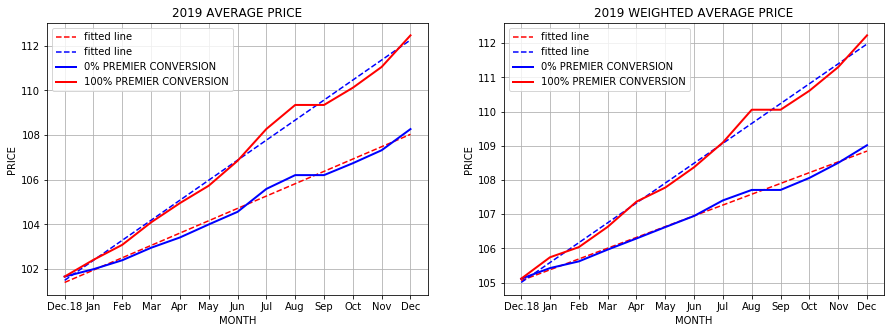

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
M = np.linspace(0,12,13, dtype = 'int32')
Month1 = ['Dec.18','Jan','Feb','Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 

X, Y = polyfit(M, a, 1)
axes[0].plot(M, X+Y*M, color = 'red', ls = '--', label = 'fitted line')
X, Y = polyfit(M, b, 1)
axes[0].plot(M, X+Y*M, color = 'blue',ls = '--', label = 'fitted line')
axes[0].plot(Month1, a, color='blue', lw = 2, linestyle='-', label = '0% PREMIER CONVERSION' )
axes[0].plot(Month1, b, color='red', lw = 2, linestyle='-', label = '100% PREMIER CONVERSION' )
axes[0].set_xlabel('MONTH')
axes[0].set_ylabel('PRICE')
axes[0].set_title('2019 AVERAGE PRICE')
axes[0].legend(loc=0) 
axes[0].grid(True)

#plt.subplot(1,2,2)
X, Y = polyfit(M, A, 1)
axes[1].plot(M,X+Y*M, color = 'red', ls = '--', label = 'fitted line')
X, Y = polyfit(M, B, 1)
axes[1].plot(M,X+Y*M, color = 'blue', ls = '--', label = 'fitted line')
axes[1].plot(Month1, A, color='blue', lw = 2, linestyle='-', label = '0% PREMIER CONVERSION' )
axes[1].plot(Month1, B, color='red', lw = 2, linestyle='-', label = '100% PREMIER CONVERSION' )
axes[1].set_xlabel('MONTH')
axes[1].set_ylabel('PRICE')
axes[1].set_title('2019 WEIGHTED AVERAGE PRICE')
axes[1].legend(loc=0) 
axes[1].grid(True)

In [25]:
'''Section 3
# Simulate random sampling and conversion of customers "standard"=>"premier"
 to determine necessary conversion targets to achieve a specific rate increase goal for the upcoming year'''

'Section 3\n# Simulate random sampling and conversion of customers "standard"=>"premier"\n to determine necessary conversion targets to achieve a specific rate increase goal for the upcoming year'

In [38]:
def weighted_average_upper(): #weighted average if ALL "standard" customers convert to "premium"
    data_weighted=data.copy()
    data_weighted['weight']=data_weighted['unit_purchased']/data_weighted['unit_purchased'].sum()
    data_weighted['rate_inc_weighted']=0
    data_weighted.loc[data_weighted['model']=='standard','rate_increase']=.15
    data_weighted.rate_inc_weighted=data_weighted.rate_increase*data_weighted.weight
    average_rate_inc=data_weighted['rate_inc_weighted'].sum()
    return average_rate_inc

In [39]:
upper=weighted_average_upper()
upper

0.06449736586992091

In [40]:
def weighted_average_0():#weighted average if NO "standard" customers convert to "premium"
    data_weighted=data.copy()
    data_weighted['weight']=data_weighted['unit_purchased']/data_weighted['unit_purchased'].sum()
    data_weighted['rate_inc_weighted']=0
    data_weighted.rate_inc_weighted=data_weighted.rate_increase*data_weighted.weight
    average_rate_inc=data_weighted['rate_inc_weighted'].sum()
    return average_rate_inc

In [41]:
lower=weighted_average_0()
lower

0.041751510073738105

In [42]:
def unweighted_simulation(percent_converted): #100 random sample simulator -- an unweighted, consumer-facing average
    average_rate_inc=[]
    while len(average_rate_inc)<100:
        data_sim=data.copy()
        rand_ind=[] #list of random indexes of 'standard' users
        while len(rand_ind)<len(data_sim[data_sim.model=='standard'])*percent_converted:
            x=np.random.randint(169,300,size=1)
            r=int(x)
            if r not in rand_ind:
                rand_ind.append(r)
            else:
                continue
        for i in rand_ind:
            data_sim.loc[i,'rate_increase']=.15
        average_rate_inc.append(data_sim['rate_increase'].mean())
    return average_rate_inc

In [43]:
def weighted_simulation(percent_converted):#100 random sample simulator -- a weighted, manager-facing average
    data_weighted=data.copy()
    data_weighted['weight']=data_weighted['unit_purchased']/data_weighted['unit_purchased'].sum()
    data_weighted['rate_inc_weighted']=0
    average_rate_inc=[]
    while len(average_rate_inc)<100:
        data_sim_w=data_weighted.copy()
        rand_ind=[]
        while len(rand_ind)<len(data_sim_w[data_sim_w.model=='standard'])*percent_converted:
            x=np.random.randint(169,300,size=1)
            r=int(x)
            if r not in rand_ind:
                rand_ind.append(r)
            else:
                continue
        for i in rand_ind:
            data_sim_w.loc[i,'rate_increase']=.15
        for i in range(0,data_sim_w['unit_purchased'].size): 
            data_sim_w.loc[i,'rate_inc_weighted']=data_sim_w.loc[i,'rate_increase']*data_weighted.loc[i,'weight']
        average_rate_inc.append(data_sim_w['rate_inc_weighted'].sum())
    return average_rate_inc


In [44]:
#Simulating random samples with 25% standard=>premier conversion--unweighted
Fifty_Percent_Conversion_Unweighted=unweighted_simulation(.5)
Fifty_Percent_Conversion_Unweighted=pd.DataFrame(Fifty_Percent_Conversion_Unweighted)
Fifty_Percent_Conversion_Unweighted.columns=['Average Rate Increase']
Fifty_Percent_Conversion_Unweighted.head()

,Average Rate Increase
0,0.083233
1,0.084900
2,0.084233
3,0.084567
4,0.085733


Text(0.5, 1.0, 'Average Rate Increase for 50% Conversion Goal')

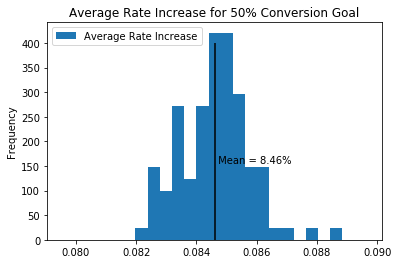

In [45]:
#plotting rate increases for simulations of random 50% conversion--unweighted
a=str(round(float(Fifty_Percent_Conversion_Unweighted.mean()*100),3))
b=float(Fifty_Percent_Conversion_Unweighted.std())
c=float(Fifty_Percent_Conversion_Unweighted.mean())
d=c-4.3*b
e=c+4.3*b
Fifty_Percent_Conversion_Unweighted.plot(y='Average Rate Increase',kind='hist',bins=25,range=(d,e),normed=True)
plt.vlines(Fifty_Percent_Conversion_Unweighted.mean(), 0, 400, colors='k', linestyles='solid', label='')
plt.text(Fifty_Percent_Conversion_Unweighted.mean(),155,' Mean = %s' % a + '%')
plt.title('Average Rate Increase for 50% Conversion Goal')

In [46]:
#Simulating random samples with 25% standard=>premier conversion--weighted
Twenty_Five_Percent_Conversion_Weighted=weighted_simulation(.25)
Twenty_Five_Percent_Conversion_Weighted=pd.DataFrame(Twenty_Five_Percent_Conversion_Weighted)
Twenty_Five_Percent_Conversion_Weighted.columns=['Average Rate Increase']
Twenty_Five_Percent_Conversion_Weighted.head()


,Average Rate Increase
0,0.045525
1,0.046600
2,0.047739
3,0.049430
4,0.046491


Text(0.5, 1.0, 'Expected Rate Increase for 25% Conversion Goal')

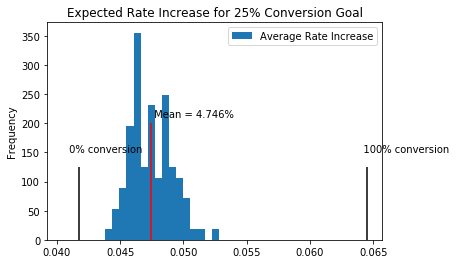

In [47]:
#plotting rate increases for simulations of random 25% conversion--weighted
a=str(round(float(Twenty_Five_Percent_Conversion_Weighted.mean()*100),3))
b=float(Twenty_Five_Percent_Conversion_Weighted.std())
c=float(Twenty_Five_Percent_Conversion_Weighted.mean())
d=c-4.3*b
e=c+4.3*b
Twenty_Five_Percent_Conversion_Weighted.plot(y='Average Rate Increase',kind='hist',bins=25,range=(d,e),normed=True)
plt.vlines(Twenty_Five_Percent_Conversion_Weighted.mean(), 0, 200, colors='r', linestyles='solid', label='')
plt.text(Twenty_Five_Percent_Conversion_Weighted.mean(),210,' Mean = %s' % a + '%')
plt.vlines(upper, 0, 125, colors='k', linestyles='solid', label='')
plt.vlines(lower, 0, 125, colors='k', linestyles='solid', label='')
plt.text(upper-.001,150,'   100% conversion')
plt.text(lower-.001,150,' 0% conversion')
plt.title('Expected Rate Increase for 25% Conversion Goal')


In [48]:
#Simulating random samples with 50% standard=>premier conversion--weighted
Fifty_Percent_Conversion_Weighted=weighted_simulation(.5)
Fifty_Percent_Conversion_Weighted=pd.DataFrame(Fifty_Percent_Conversion_Weighted)
Fifty_Percent_Conversion_Weighted.columns=['Average Rate Increase']

Text(0.5, 1.0, 'Average Rate Increase for 50% Conversion Goal')

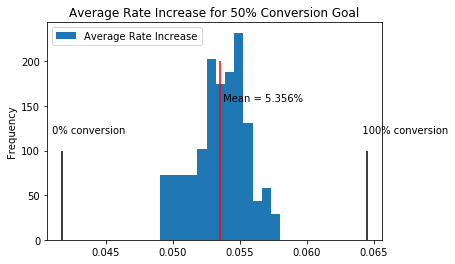

In [49]:
#plotting rate increases for simulations of random 50% conversion--weighted
a=str(round(float(Fifty_Percent_Conversion_Weighted.mean()*100),3))
b=float(Fifty_Percent_Conversion_Weighted.std())
c=float(Fifty_Percent_Conversion_Weighted.mean())
d=c-4.3*b
e=c+4.3*b
Fifty_Percent_Conversion_Weighted.plot(y='Average Rate Increase',kind='hist',bins=25,range=(d,e),normed=True)
plt.vlines(Fifty_Percent_Conversion_Weighted.mean(), 0, 200, colors='r', linestyles='solid', label='')
plt.text(Fifty_Percent_Conversion_Weighted.mean(),155,' Mean = %s' % a + '%')
plt.vlines(upper, 0, 100, colors='k', linestyles='solid', label='')
plt.vlines(lower, 0, 100, colors='k', linestyles='solid', label='')
plt.text(upper-.001,120,'   100% conversion')
plt.text(lower-.001,120,' 0% conversion')
plt.title('Average Rate Increase for 50% Conversion Goal')

In [50]:
#Simulating random samples with 75% standard=>premier conversion--weighted
Seventy_Five_Percent_Conversion_Weighted=weighted_simulation(.75)
Seventy_Five_Percent_Conversion_Weighted=pd.DataFrame(Seventy_Five_Percent_Conversion_Weighted)
Seventy_Five_Percent_Conversion_Weighted.columns=['Average Rate Increase']


Text(0.5, 1.0, 'Expected Rate Increase for 75% Conversion Goal')

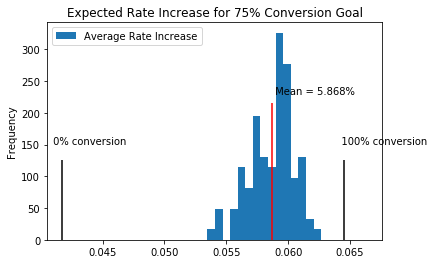

In [51]:
#plotting rate increases for simulations of random 75% conversion--weighted
a=str(round(float(Seventy_Five_Percent_Conversion_Weighted.mean()*100),3))
b=float(Seventy_Five_Percent_Conversion_Weighted.std())
c=float(Seventy_Five_Percent_Conversion_Weighted.mean())
d=c-4.3*b
e=c+4.3*b
Seventy_Five_Percent_Conversion_Weighted.plot(y='Average Rate Increase',kind='hist',bins=25,range=(d,e),normed=True)
plt.vlines(Seventy_Five_Percent_Conversion_Weighted.mean(), 0, 215, colors='r', linestyles='solid', label='')
plt.text(Seventy_Five_Percent_Conversion_Weighted.mean(),230,' Mean = %s' % a + '%')
plt.vlines(upper, 0, 125, colors='k', linestyles='solid', label='')
plt.vlines(lower, 0, 125, colors='k', linestyles='solid', label='')
plt.text(upper-.001,150,'   100% conversion')
plt.text(lower-.001,150,' 0% conversion')
plt.title('Expected Rate Increase for 75% Conversion Goal')
